<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/book2/18/deepgp_stepdata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step Data using Deep Gaussian Process

In [1]:
try:
    import deepgp
except ModuleNotFoundError:
    %pip install git+https://github.com/SheffieldML/PyDeepGP.git
    import deepgp

try:
    import GPy
except ModuleNotFoundError:
    %pip install -qq GPy
    import GPy

try:
    from probml_utils import latexify, savefig, is_latexify_enabled
except ModuleNotFoundError:
    %pip install git+https://github.com/probml/probml-utils.git
    from probml_utils import latexify, savefig, is_latexify_enabled

try:
    import tinygp
except ModuleNotFoundError:
    %pip install -q tinygp
    import tinygp

# import display
import seaborn as sns
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from tinygp import kernels, GaussianProcess
#from jax.config import config

import numpy as np

try:
    import jaxopt
except ModuleNotFoundError:
    %pip install jaxopt
    import jaxopt
#config.update("jax_enable_x64", True)

latexify(width_scale_factor=2, fig_height=1.75)
marksize = 3 if is_latexify_enabled() else 4

RuntimeError: module was compiled against NumPy C-API version 0x10 (NumPy 1.23) but the running NumPy has C-API version 0xf. Check the section C-API incompatibility at the Troubleshooting ImportError section at https://numpy.org/devdocs/user/troubleshooting-importerror.html#c-api-incompatibility for indications on how to solve this problem.

 /usr/local/lib/python3.10/dist-packages/probml_utils/plotting.py:25: UserWarning:LATEXIFY environment variable not set, not latexifying


## Step Data

2024-11-23 17:51:56.411379: W external/xla/xla/service/gpu/nvptx_compiler.cc:893] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version 12.6.77. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


(-2.0, 2.0)

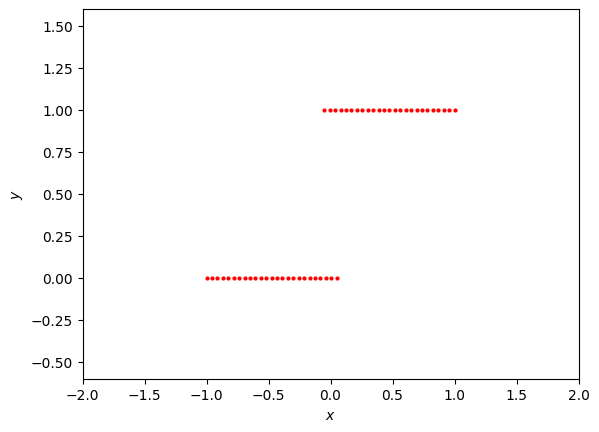

In [2]:
num_low = 25
num_high = 25
gap = -0.1
noise = 0.0001
x = jnp.vstack(
    (jnp.linspace(-1, -gap / 2.0, num_low)[:, jnp.newaxis], jnp.linspace(gap / 2.0, 1, num_high)[:, jnp.newaxis])
).reshape(
    -1,
)
y = jnp.vstack((jnp.zeros((num_low, 1)), jnp.ones((num_high, 1))))
scale = jnp.sqrt(y.var())
offset = y.mean()
yhat = ((y - offset) / scale).reshape(
    -1,
)

fig = plt.figure()
plt.plot(x, y, "r.", markersize=marksize)
plt.xlabel("$x$")
plt.ylabel("$y$")
xlim = (-2, 2)
ylim = (-0.6, 1.6)
plt.ylim(ylim)
plt.xlim(xlim)

## GPy

In [3]:
def neg_log_likelihood(theta, X, y):
    kernel = jnp.exp(theta["log_amp"]) * kernels.ExpSquared(scale=jnp.exp(theta["log_scale"]))
    gp = GaussianProcess(kernel, X, diag=jnp.exp(theta["log_diag"]))
    return -gp.log_probability(y)


theta_init = {"log_scale": jnp.log(1.0), "log_diag": jnp.log(1.0), "log_amp": jnp.log(1.0)}
obj = jax.jit(jax.value_and_grad(neg_log_likelihood))
solver = jaxopt.ScipyMinimize(fun=neg_log_likelihood, method="L-BFGS-B")
soln = solver.run(
    theta_init,
    X=x,
    y=y.reshape(
        -1,
    ),
)

kernel = jnp.exp(soln.params["log_amp"]) * kernels.ExpSquared(scale=jnp.exp(soln.params["log_scale"]))
gp = GaussianProcess(kernel, x, diag=jnp.exp(soln.params["log_diag"]))

xnew = jnp.vstack(
    (jnp.linspace(-2, -gap / 2.0, 25)[:, jnp.newaxis], jnp.linspace(gap / 2.0, 2, 25)[:, jnp.newaxis])
).reshape(
    -1,
)
cond_gp = gp.condition(
    y.reshape(
        -1,
    ),
    xnew,
).gp
mu, var = cond_gp.loc, cond_gp.variance

var = var + jnp.exp(soln.params["log_diag"])

## Plotting GP Fit

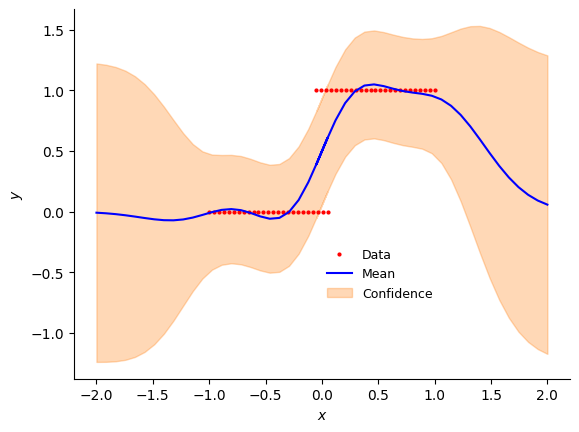

In [5]:
fig = plt.figure()
latexify(width_scale_factor=2, fig_height=1.75)

plt.plot(x, y, "r.", markersize=marksize)
plt.plot(xnew, mu, "blue", markersize=marksize)
plt.fill_between(
    xnew.flatten(),
    mu.flatten() - 1.96 * jnp.sqrt(var),
    mu.flatten() + 1.96 * jnp.sqrt(var),
    alpha=0.3,
    color="C1",
)

sns.despine()
legendsize = 5 if is_latexify_enabled() else 9
plt.legend(labels=["Data", "Mean", "Confidence"], loc=(0.5, 0.2), prop={"size": legendsize}, frameon=False)
# ax.title("$(l, \sigma_f, \sigma_y)=${}, {}, {}".format(length_scale, sigma_f, sigma_y))
plt.xlabel("$x$")
plt.ylabel("$y$")

savefig("gp_stepdata_fit")
plt.show()

## Deep GP

In [6]:
num_hidden = 3
latent_dim = 1

kernels = [*[GPy.kern.RBF(latent_dim, ARD=True)] * num_hidden]  # hidden kernels
kernels.append(GPy.kern.RBF(np.array(x.reshape(-1, 1)).shape[1]))  # we append a kernel for the input layer

m = deepgp.DeepGP(
    # this describes the shapes of the inputs and outputs of our latent GPs
    [y.reshape(-1, 1).shape[1], *[latent_dim] * num_hidden, x.reshape(-1, 1).shape[1]],
    X=np.array(x.reshape(-1, 1)),  # training input
    Y=np.array(y.reshape(-1, 1)),  # training outout
    inits=[*["PCA"] * num_hidden, "PCA"],  # initialise layers
    kernels=kernels,
    num_inducing=x.shape[0],
    back_constraint=False,
)
m.initialize_parameter()
# display(m)

## Optimizing Deep GP

In [7]:
def optimise_dgp(model, messages=True):
    """Utility function for optimising deep GP by first
    reinitiailising the Gaussian noise at each layer
    (for reasons pertaining to stability)
    """
    model.initialize_parameter()
    for layer in model.layers:
        layer.likelihood.variance.constrain_positive(warning=False)
        layer.likelihood.variance = 1.0  # small variance may cause collapse
    model.optimize(messages=messages, max_iters=10000)


optimise_dgp(m, messages=True)

In [8]:
# m.optimize_restarts(num_restarts=5)
mu_dgp, var_dgp = m.predict(xnew.reshape(-1, 1))

 /usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:68: UserWarning:Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
 /usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:68: UserWarning:Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.


## Samples from Data

In [9]:
def sample_dgp(model, X, num_samples=1, include_likelihood=True):
    samples = []
    jitter = 1e-5
    count, num_tries = 0, 100
    while len(samples) < num_samples:
        next_input = X
        if count > num_tries:
            print("failed to sample")
            break
        try:
            count = count + 1
            for layer in reversed(model.layers):
                mu_k, sig_k = layer.predict(next_input, full_cov=True, include_likelihood=include_likelihood)
                sample_k = mu_k + np.linalg.cholesky(sig_k + jitter * np.eye(X.shape[0])) @ np.random.randn(*X.shape)
                next_input = sample_k
            samples.append(sample_k)
            count = 0
        except:
            pass

    return samples if num_samples > 1 else samples[0]

## Plot Deep GP fit without samples

 /usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:68: UserWarning:Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
 /usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:68: UserWarning:Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
 /usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:68: UserWarning:Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 

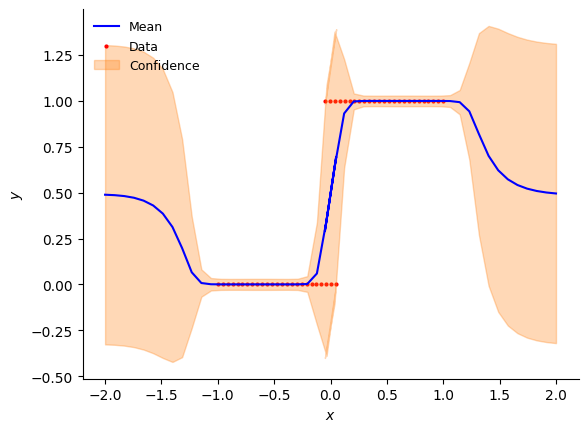

In [10]:
plt.figure()
num = 5
sample = sample_dgp(m, xnew.reshape(-1, 1), num, include_likelihood=False)
latexify(width_scale_factor=2, fig_height=1.75)
plt.plot(xnew, mu_dgp, "blue")
plt.scatter(x, y, c="r", s=marksize)
plt.fill_between(
    xnew.flatten(),
    mu_dgp.flatten() - 1.96 * jnp.sqrt(var_dgp.flatten()),
    mu_dgp.flatten() + 1.96 * jnp.sqrt(var_dgp.flatten()),
    alpha=0.3,
    color="C1",
)
sns.despine()
legendsize = 4.5 if is_latexify_enabled() else 9
plt.legend(labels=["Mean", "Data", "Confidence"], loc=2, prop={"size": legendsize}, frameon=False)
plt.xlabel("$x$")
plt.ylabel("$y$")
sns.despine()
plt.show()

## Plot Deep GP fit with samples

 /usr/local/lib/python3.10/dist-packages/probml_utils/plotting.py:84: UserWarning:set FIG_DIR environment variable to save figures


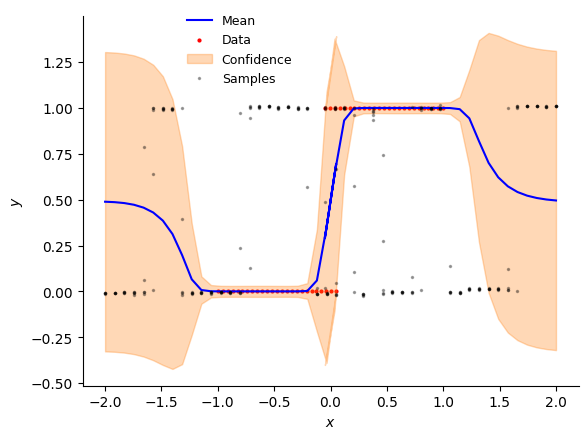

In [11]:
plt.figure()
latexify(width_scale_factor=2, fig_height=1.75)
plt.plot(xnew, mu_dgp, "b")
plt.scatter(x, y, c="r", s=marksize)
plt.fill_between(
    xnew.flatten(),
    mu_dgp.flatten() - 1.96 * jnp.sqrt(var_dgp.flatten()),
    mu_dgp.flatten() + 1.96 * jnp.sqrt(var_dgp.flatten()),
    alpha=0.3,
    color="C1",
)
plt.plot(xnew, np.array(sample).reshape(-1, num), "k.", markersize=3, alpha=0.3)
sns.despine()
legendsize = 5 if is_latexify_enabled() else 9
plt.legend(labels=["Mean", "Data", "Confidence", "Samples"], loc=(0.2, 0.8), prop={"size": legendsize}, frameon=False)
plt.xlabel("$x$")
plt.ylabel("$y$")
savefig("deep_gp_stepdata_fit")
plt.show()

## Plot Input to each Deep GP layers

 /usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:68: UserWarning:Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
 /usr/local/lib/python3.10/dist-packages/jax/_src/numpy/array_methods.py:68: UserWarning:Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
 /usr/local/lib/python3.10/dist-packages/probml_utils/plotting.py:84: UserWarning:set FIG_DIR environment variable to save figures
 /usr/local/lib/python3.10/dist-packages/probml_utils/plotting.py:25: UserWarning:LATEXIFY environment variable not

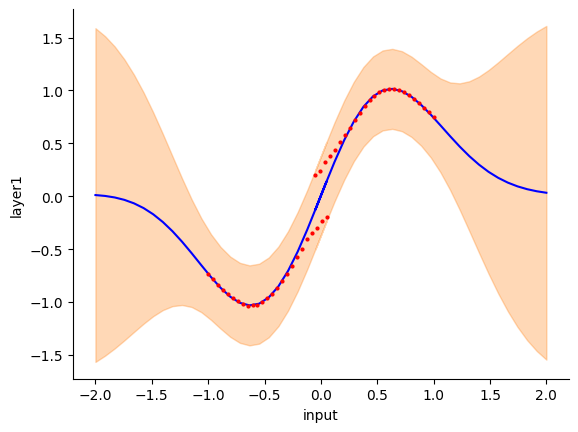

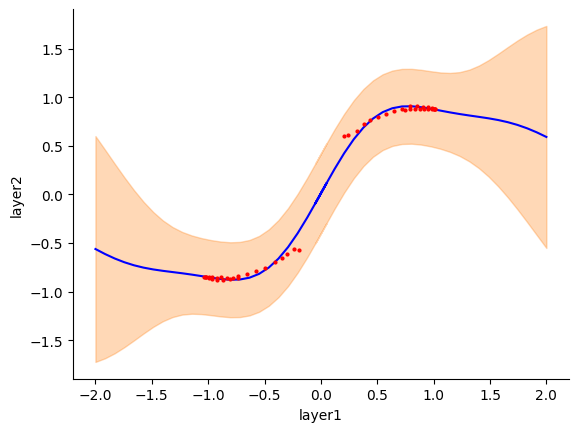

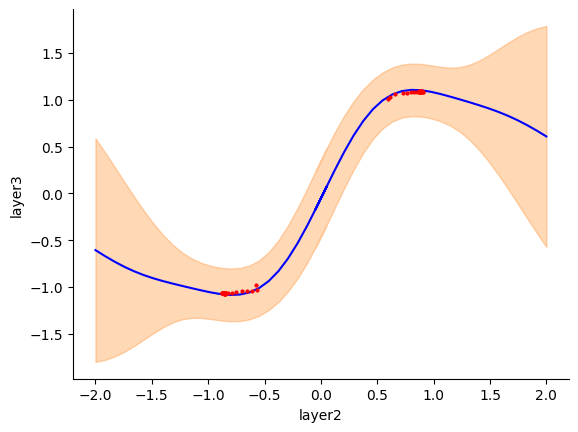

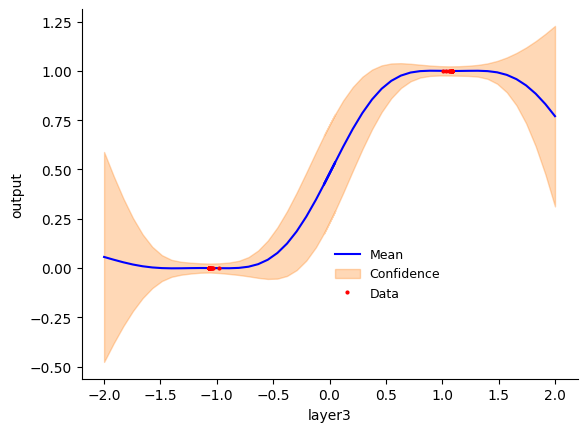

In [12]:
def plot_dgp_layers(model, X, training_points=True):
    """Plot mappings between layers in a deep GP"""

    num_layers = len(model.layers)
    layer_input = X

    # The layers in a deep GP are ordered from observation to input,
    layers_name = ["layer1", "layer2", "layer3"]
    layers = list(reversed(model.layers))
    for i, layer in enumerate(layers):
        plt.figure()
        latexify(width_scale_factor=2, fig_height=1.75)
        mu_i, var_i = layer.predict(layer_input, include_likelihood=True)
        plt.plot(layer_input, mu_i, "blue")
        plt.fill_between(
            layer_input[:, 0],
            mu_i.flatten() - 1.96 * jnp.sqrt(var_i.flatten()),
            mu_i.flatten() + 1.96 * jnp.sqrt(var_i.flatten()),
            alpha=0.3,
            color="C1",
        )

        plt.ylabel(layers_name[i] if i < len(layers) - 1 else "output")
        plt.xlabel(layers_name[i - 1] if i > 0 else "input")
        if training_points:  # Plot propagated training points
            plt.plot(
                layer.X.mean.values if i > 0 else layer.X,
                layer.Y.mean.values if i < num_layers - 1 else layer.Y,
                "r.",
                markersize=marksize,
            )

        legendsize = 6 if is_latexify_enabled() else 9
        if i == 3:
            plt.legend(labels=["Mean", "Confidence", "Data"], loc=(0.5, 0.2), prop={"size": legendsize}, frameon=False)
        sns.despine()
        savefig("deep_gp_input_layer{}".format(i + 1))


plot_dgp_layers(m, xnew.reshape(-1, 1))